# Download spotify data, prepare dataframe

In [1]:
import os
import random
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def extract_playlist_info(data):
    spotify_dict = {'playlist_id': [], 'playlist_name': [], 'artist_name': [], 'track_name': []}
    for playlist in data['playlists']:
        pid = playlist['pid']
        name = playlist['name']
        for track in playlist['tracks']:
            artist_name = track['artist_name']
            track_name = track['track_name']
            spotify_dict['playlist_id'].append(pid)
            spotify_dict['playlist_name'].append(name)
            spotify_dict['artist_name'].append(artist_name)
            spotify_dict['track_name'].append(track_name)
    return pd.DataFrame(spotify_dict)

In [3]:
json_files = os.listdir('./data')
random.seed(123)
random_files = random.sample(json_files, 2)
print(random_files)

['mpd.slice.738000-738999.json', 'mpd.slice.783000-783999.json']


In [4]:
json_files = os.listdir('./data')
random.seed(123)
random_files = random.sample(json_files, 2)
df = pd.DataFrame()

for file in random_files:
    json_path = './data/' + file
    with open(json_path) as f:
        data = json.load(f)
    df = pd.concat([df, extract_playlist_info(data)])
df.to_csv('./data_CSV/spotify_data.csv', index=False)

In [5]:
df = pd.read_csv('./data_CSV/spotify_data.csv')
df

,playlist_id,playlist_name,artist_name,track_name
0,738000,College,Cameo,Word Up
1,738000,College,Cameo,Candy
2,738000,College,Club Nouveau,Rumors
3,738000,College,Club Nouveau,Situation #9
4,738000,College,MC Hammer,U Can't Touch This
...,...,...,...,...
133991,783999,Social,MKTO,Classic
133992,783999,Social,The Script,Hall of Fame
133993,783999,Social,Jack Johnson,Better Together
133994,783999,Social,Jason Derulo,Trumpets


In [6]:
# filter artists who appear more than 10 times
df = pd.read_csv('./data_CSV/spotify_data.csv')
artist_counts = df['artist_name'].value_counts()
artist_counts = artist_counts[artist_counts > 10]
df = df[df['artist_name'].isin(artist_counts.index)]

In [7]:
df
# replace artist name Joe Bada$$ with Joe Badass
df['artist_name'] = df['artist_name'].replace('Joey Bada$$', 'Joey Badass')

In [8]:
cooccurrences = df.groupby('playlist_id')['artist_name'].apply(lambda x: list(set(x))).reset_index()

# Filter 

In [9]:
cooccurrences

,playlist_id,artist_name
0,738000,"[Bette Midler, Run–D.M.C., Nena, John Mellenca..."
1,738001,"[Ludwig van Beethoven, Franz Schubert, Franz L..."
2,738002,"[Shakira, Fitz and The Tantrums, Quinn XCII, M..."
3,738003,"[G-Eazy, Låpsley, Earl Sweatshirt, Marian Hill..."
4,738004,"[Major Lazer, Snoop Dogg, Bryson Tiller, Zay H..."
...,...,...
1976,783995,"[Klaypex, G-Eazy, MiMS, Blue Foundation, Holly..."
1977,783996,"[Manu Chao, MIKA, Cœur De Pirate, Alex Nevsky,..."
1978,783997,[lynch.]
1979,783998,"[Eiffel 65, Hannah Montana, Kidz Bop Kids, Fer..."


In [10]:
G = nx.Graph()
for artists in cooccurrences['artist_name']:
    for artist1 in artists:
        for artist2 in artists:
            if artist1 != artist2:
                if G.has_edge(artist1, artist2):
                    G[artist1][artist2]['weight'] += 1
                else:
                    G.add_edge(artist1, artist2, weight=1)

In [49]:
cooccurrences.to_csv('./data_CSV/cooccurrences.csv', index=False)

In [54]:
top_10_coocurrences = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]

In [56]:
top_10_coocurrences[0][2]['weight']

362

In [57]:
# get top 10 edges with highest weight
top_10_coocurrences = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]
artist1 = []
artist2 = []
weight = []
for coocurrence in top_10_coocurrences:
    artist1.append(coocurrence[0])
    artist2.append(coocurrence[1])
    weight.append(coocurrence[2]['weight'])

colors = sns.color_palette("husl", 10)
top_10_coocurrences = pd.DataFrame({'artist1': artist1, 'artist2': artist2, 'weight': weight})

In [60]:
colors = sns.color_palette("husl", 10)
top_10_coocurrences = pd.DataFrame(top_10_coocurrences, columns=['artist1', 'artist2', 'weight'])
top_10_coocurrences['artists_combined'] = top_10_coocurrences['artist1'] + ' - ' + top_10_coocurrences['artist2']

In [61]:
top_10_coocurrences

,artist1,artist2,weight,artists_combined
0,Drake,Kanye West,362,Drake - Kanye West
1,Drake,Kendrick Lamar,308,Drake - Kendrick Lamar
2,Drake,The Weeknd,292,Drake - The Weeknd
3,Drake,Rihanna,274,Drake - Rihanna
4,Drake,Future,270,Drake - Future
5,Drake,Big Sean,264,Drake - Big Sean
6,Kanye West,Kendrick Lamar,262,Kanye West - Kendrick Lamar
7,Drake,J. Cole,256,Drake - J. Cole
8,Drake,Migos,234,Drake - Migos
9,Rae Sremmurd,Drake,228,Rae Sremmurd - Drake


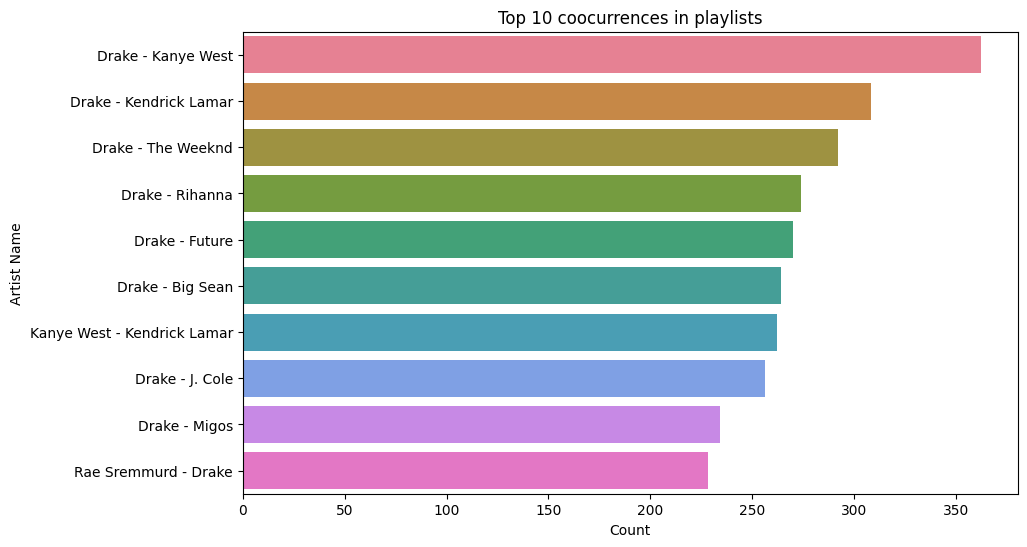

In [63]:
plt.figure(figsize=(10, 6))
sns.barplot(x='weight', y='artists_combined', data=top_10_coocurrences, palette=colors)

plt.xlabel('Count')
plt.ylabel('Artist Name')
plt.title('Top 10 coocurrences in playlists')

plt.show()

In [22]:
len(G.nodes())

2100

# Without largest component

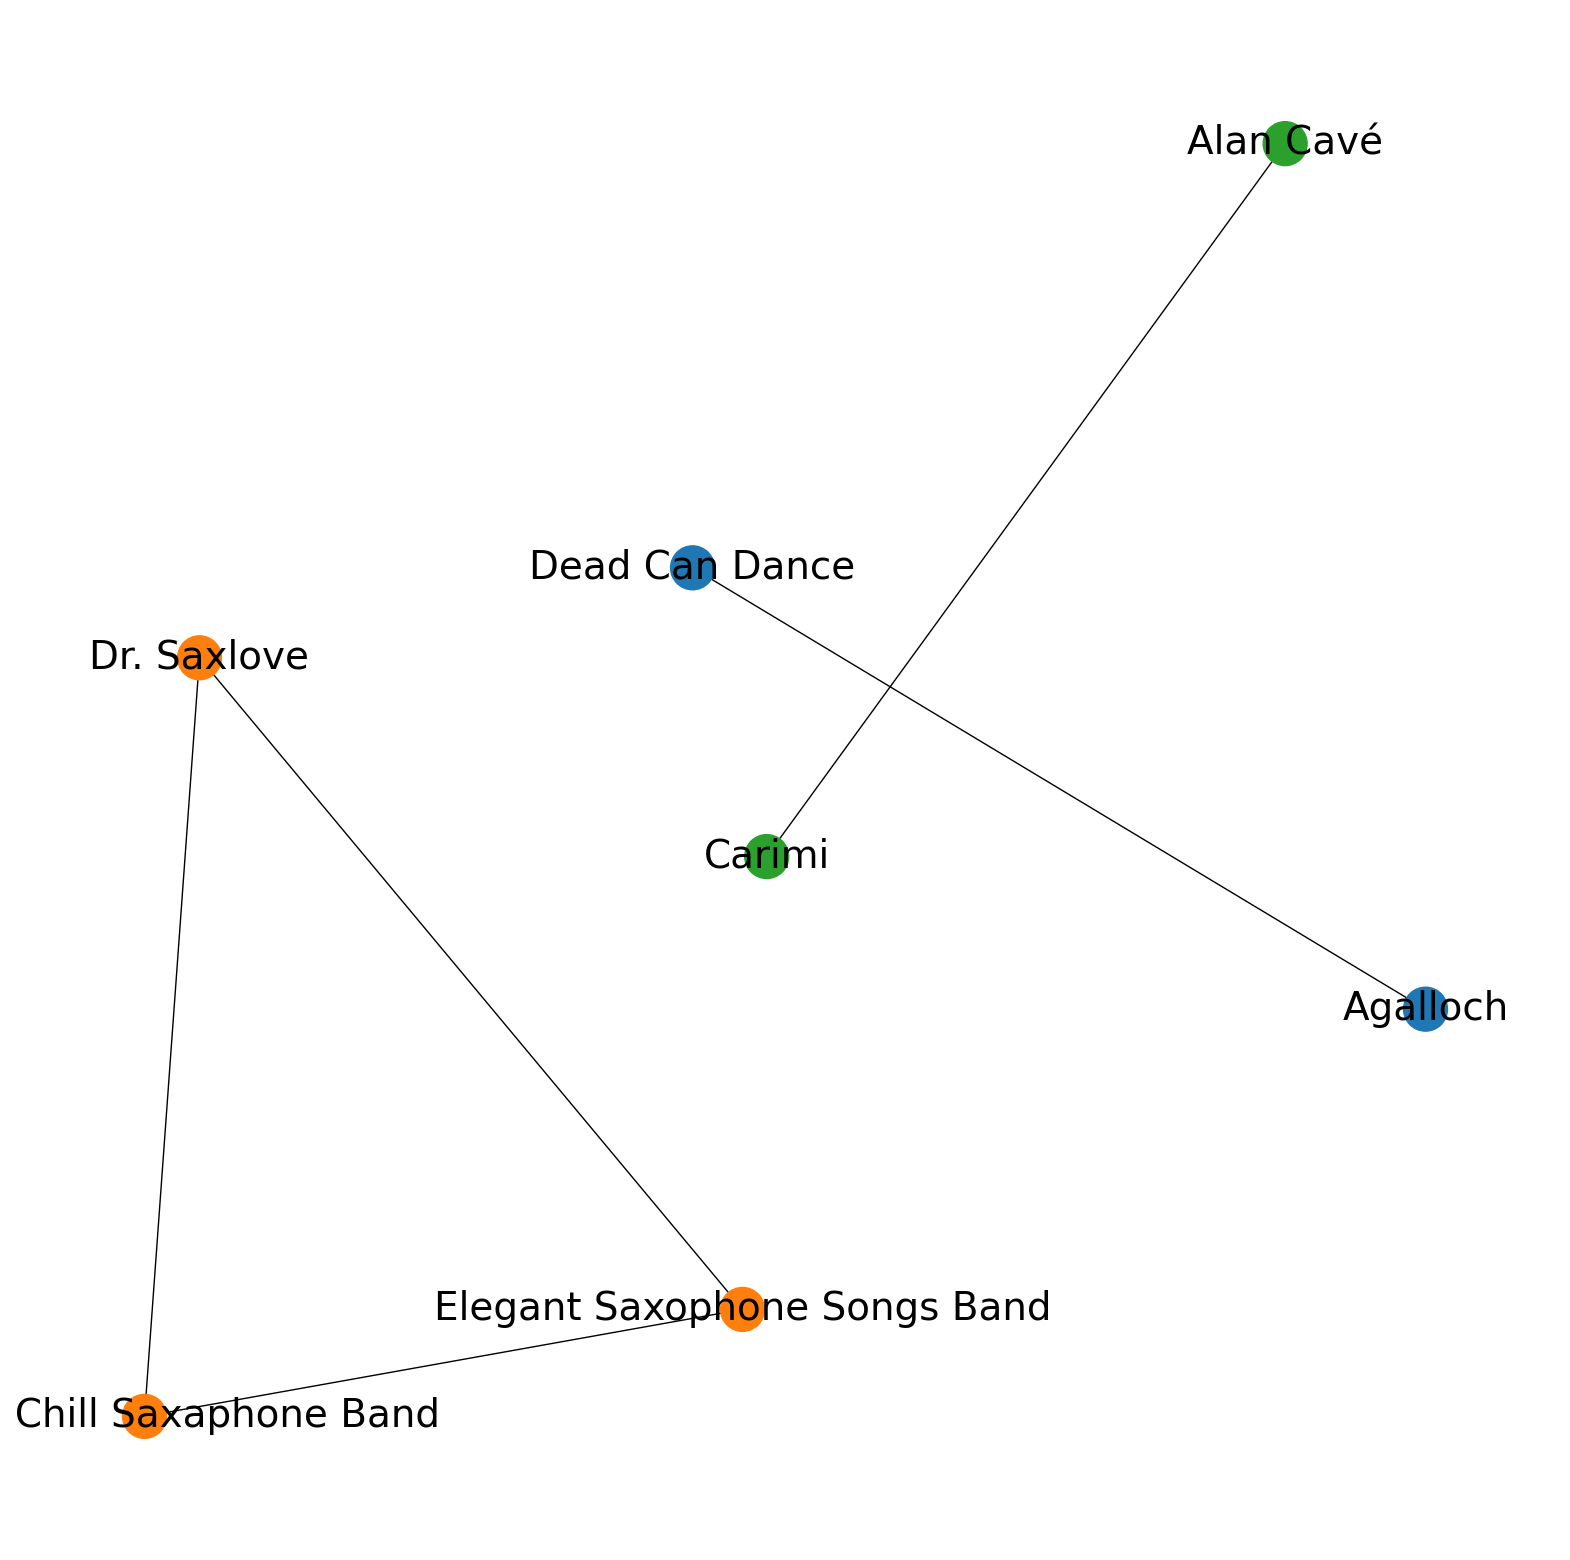

In [39]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import cycle

# Assuming you already have a graph G

# Get connected components
components = list(nx.connected_components(G))

# Find the largest connected component
largest_component = max(components, key=len)

# Remove nodes in the largest connected component from the graph
G_without_largest = G.copy()
G_without_largest.remove_nodes_from(largest_component)

# Generate a color map for nodes based on connected components (excluding the largest)
color_map = {}
color_cycle = cycle(plt.cm.tab10.colors)  # You can use a different colormap if needed

for i, component in enumerate(components):
    if component != largest_component:
        color = next(color_cycle)
        for node in component:
            color_map[node] = color

# Draw the graph with node colors
node_colors = [color_map[node] for node in G_without_largest.nodes]

fig, ax = plt.subplots(figsize=(20, 20))
pos = nx.spring_layout(G_without_largest, iterations=5)
nx.draw(G_without_largest, pos=pos, node_color=node_colors, with_labels=True, font_size=28, node_size=1000)

plt.show()


# Largest component with pagerank as node size

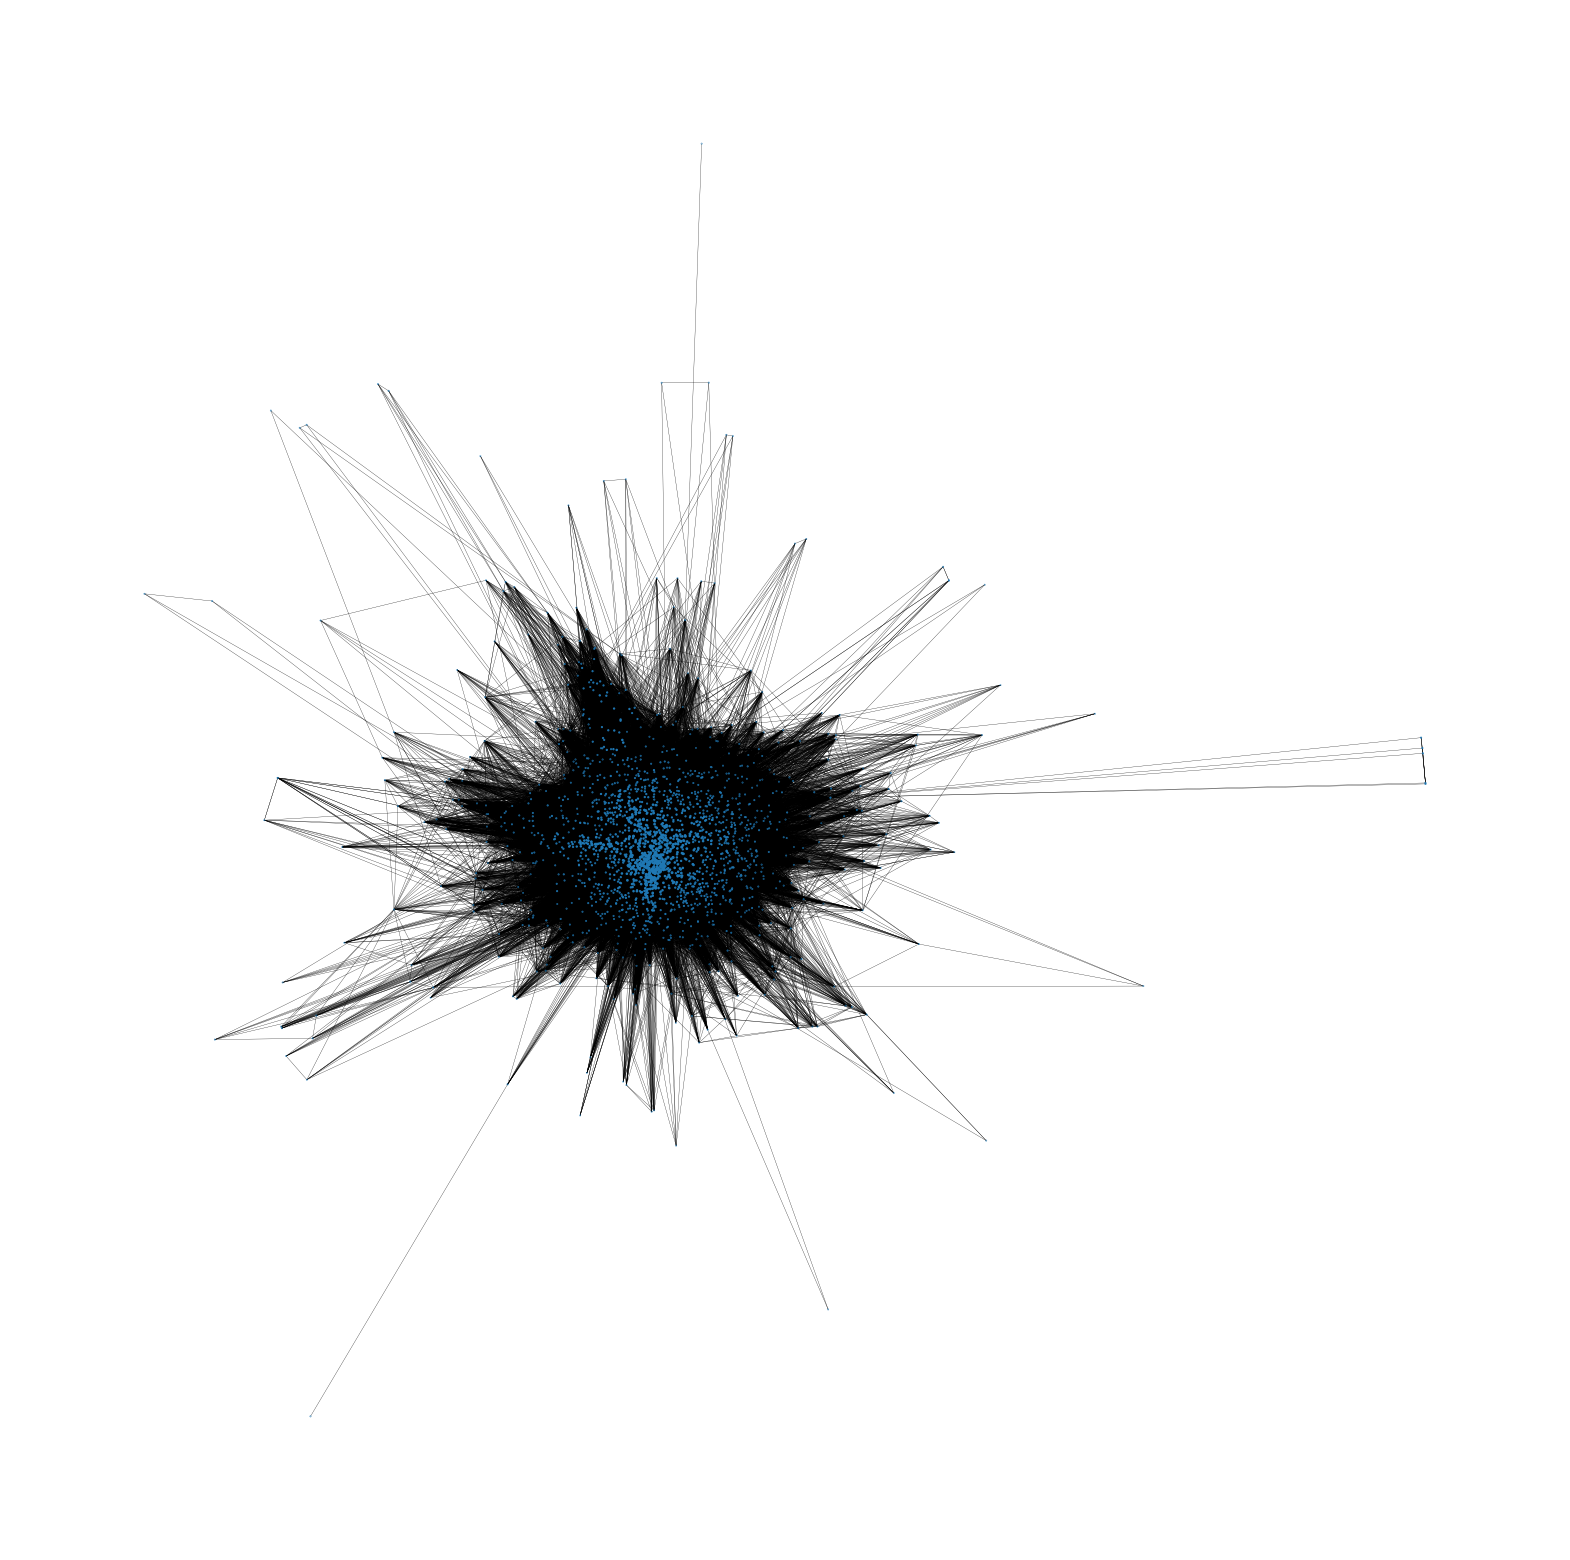

In [70]:
largest_component = max(nx.connected_components(G), key=len)

G0 = G.subgraph(largest_component)

pagerank_values = nx.pagerank(G0)
pos = nx.spring_layout(G0, iterations=100)
scaled_pagerank = [pagerank_values[node] * 1000 for node in G0.nodes]
fig, ax = plt.subplots(figsize=(20, 20))

nx.draw(G0, pos=pos,  with_labels=False, node_size=scaled_pagerank, font_size=8, font_color='black', width=0.2)


plt.show()


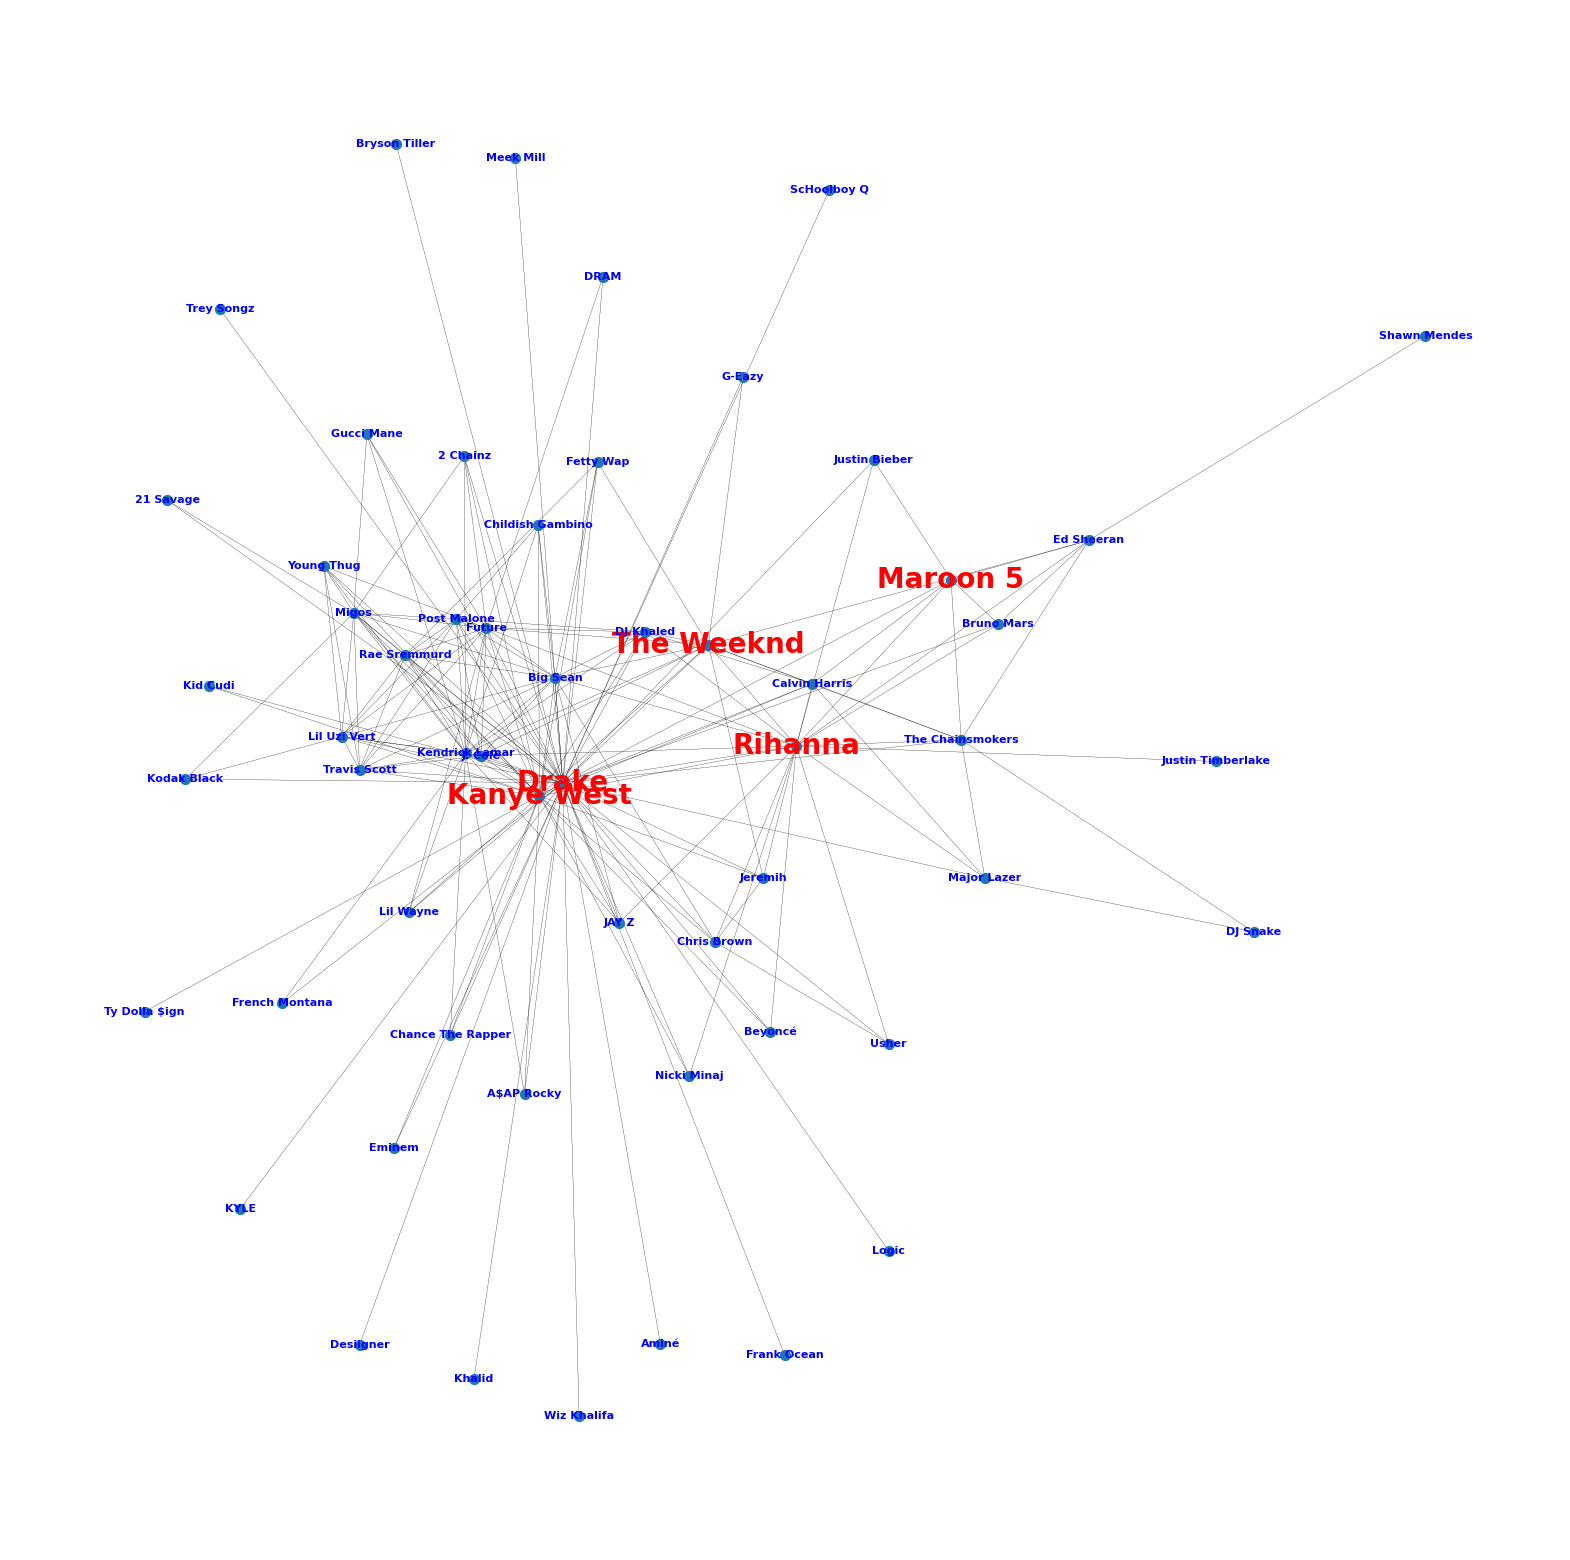

In [122]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming you already have a graph G

largest_component = max(nx.connected_components(G), key=len)
G0 = G.subgraph(largest_component)

# Get the top 100 edges with highest weights
top_edges = sorted(G0.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:200]

# Create a subgraph with the top 100 edges
G_top_edges = nx.Graph(top_edges)
# extract top connected component
largest_component = max(nx.connected_components(G_top_edges), key=len)
G_top_edges = G_top_edges.subgraph(largest_component)
# Calculate PageRank values for the original graph
pagerank_values = nx.pagerank(G0)

# Get the top 5 nodes based on PageRank
top5_nodes = sorted(pagerank_values, key=pagerank_values.get, reverse=True)[:5]
rest_nodes = [node for node in G_top_edges.nodes if node not in top5_nodes]

# Draw the subgraph with labels for the top 5 nodes
pos = nx.spring_layout(G_top_edges)
fig, ax = plt.subplots(figsize=(20, 20))

# Draw nodes and edges
nx.draw(G_top_edges, pos=pos, with_labels=False, node_size=50, font_size=8, font_color='black', width=0.2)

# Add labels for the top 5 nodes
labels = {node: node for node in top5_nodes}
labels2 = {node: node for node in rest_nodes}
nx.draw_networkx_labels(G_top_edges, pos, labels, font_size=20, font_color='red', font_weight='bold')
nx.draw_networkx_labels(G_top_edges, pos, labels2, font_size=8, font_color='blue', font_weight='bold')

plt.show()


# metrics

In [123]:
assortativity = nx.degree_assortativity_coefficient(G0)

In [124]:
assortativity

-0.07466986087661137

In [74]:
import networkx as nx
import pandas as pd

# Assuming you already have a graph G

largest_component = max(nx.connected_components(G), key=len)
G0 = G.subgraph(largest_component)

# Calculate various network metrics
metrics = {
    "Number of Nodes": G0.number_of_nodes(),
    "Number of Edges": G0.number_of_edges(),
    "Average Degree": sum(dict(G0.degree()).values()) / G0.number_of_nodes(),
    "Density": nx.density(G0),
    "Global Clustering Coefficient": nx.average_clustering(G0),
    "Average Shortest Path Length": nx.average_shortest_path_length(G0),
    "Diameter": nx.diameter(G0),
    "Assortativity": nx.degree_assortativity_coefficient(G0),
}

# Convert metrics dictionary to DataFrame
metrics_df = pd.DataFrame(list(metrics.items()), columns=["Metric", "Value"])

# Display the DataFrame
print(metrics_df)


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming you already have a graph G

largest_component = max(nx.connected_components(G), key=len)
G0 = G.subgraph(largest_component)

pagerank_values = nx.pagerank(G0)
top_nodes = sorted(pagerank_values, key=pagerank_values.get, reverse=True)[:5]

pos = nx.spring_layout(G0, iterations=100)
scaled_pagerank = [pagerank_values[node] * 1000 for node in G0.nodes]

fig, ax = plt.subplots(figsize=(20, 20))

# Draw nodes with scaled size
nx.draw(G0, pos=pos, with_labels=False, node_size=scaled_pagerank, font_size=8, font_color='black', width=0.2)

# Add labels for the top 5 nodes
labels = {node: node for node in top_nodes}
nx.draw_networkx_labels(G0, pos, labels, font_size=10, font_color='red')

plt.show()


# Histogram of node degrees

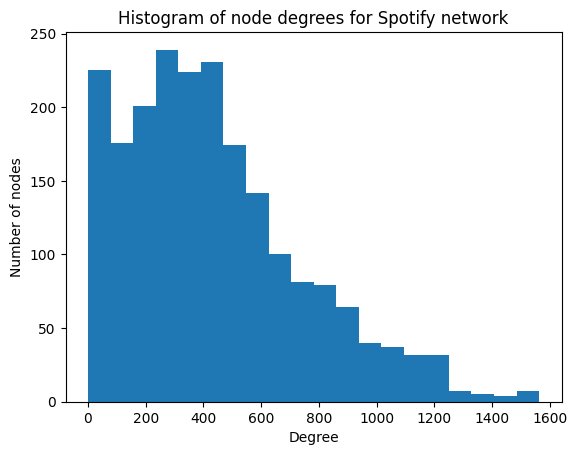

In [28]:
# histogram of node degrees
degrees = [val for (node, val) in G.degree()]
plt.hist(degrees, bins=20)
# log scale on y and x axis
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Histogram of node degrees for Spotify network')
plt.show()

# Communities

In [22]:
from networkx.algorithms import community

In [39]:
communities = community.greedy_modularity_communities(G0)

In [40]:
len(communities)

7

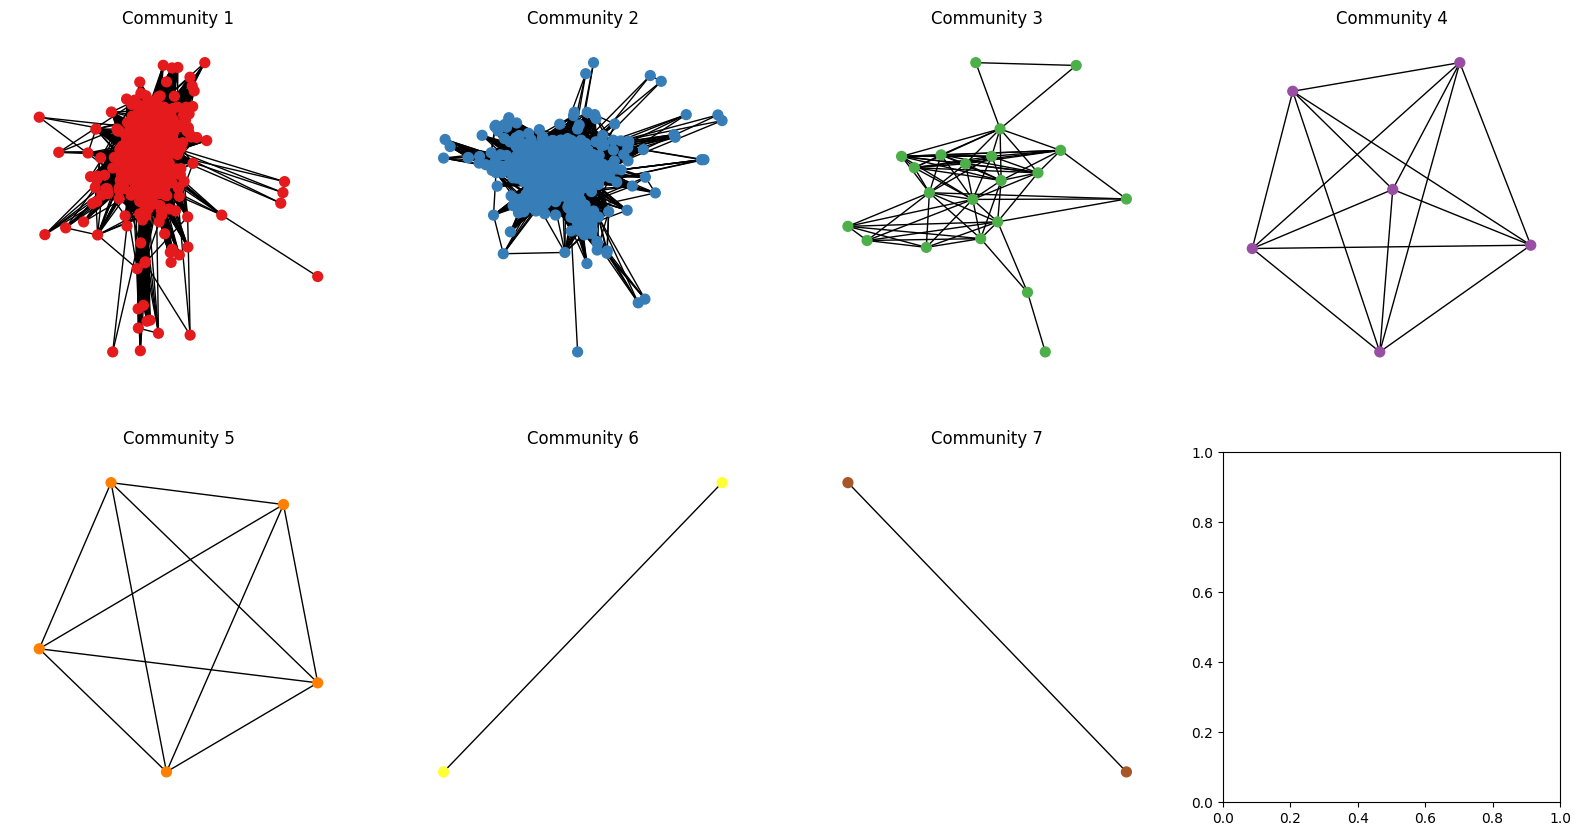

In [53]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community

# Assuming you already have a graph G
largest_component = max(nx.connected_components(G), key=len)
G0 = G.subgraph(largest_component)

# Detect communities using the greedy modularity algorithm
communities = list(community.greedy_modularity_communities(G0))

# Create a 2x4 subplot grid
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# get 7 colors
colors = plt.cm.Set1.colors

# Flatten the 2D array of subplots to simplify indexing
axs = axs.flatten()

# Iterate over communities and draw subgraphs
for i, comm_nodes in enumerate(communities):
    # Create a subgraph for the community
    subgraph = G0.subgraph(comm_nodes)
    
    # Draw the subgraph with a distinct color
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos=pos, node_size=50, ax=axs[i], node_color=[colors[i]] * len(subgraph.nodes()), font_size=12)
    
    axs[i].set_title(f'Community {i + 1}')

plt.show()


# Pop

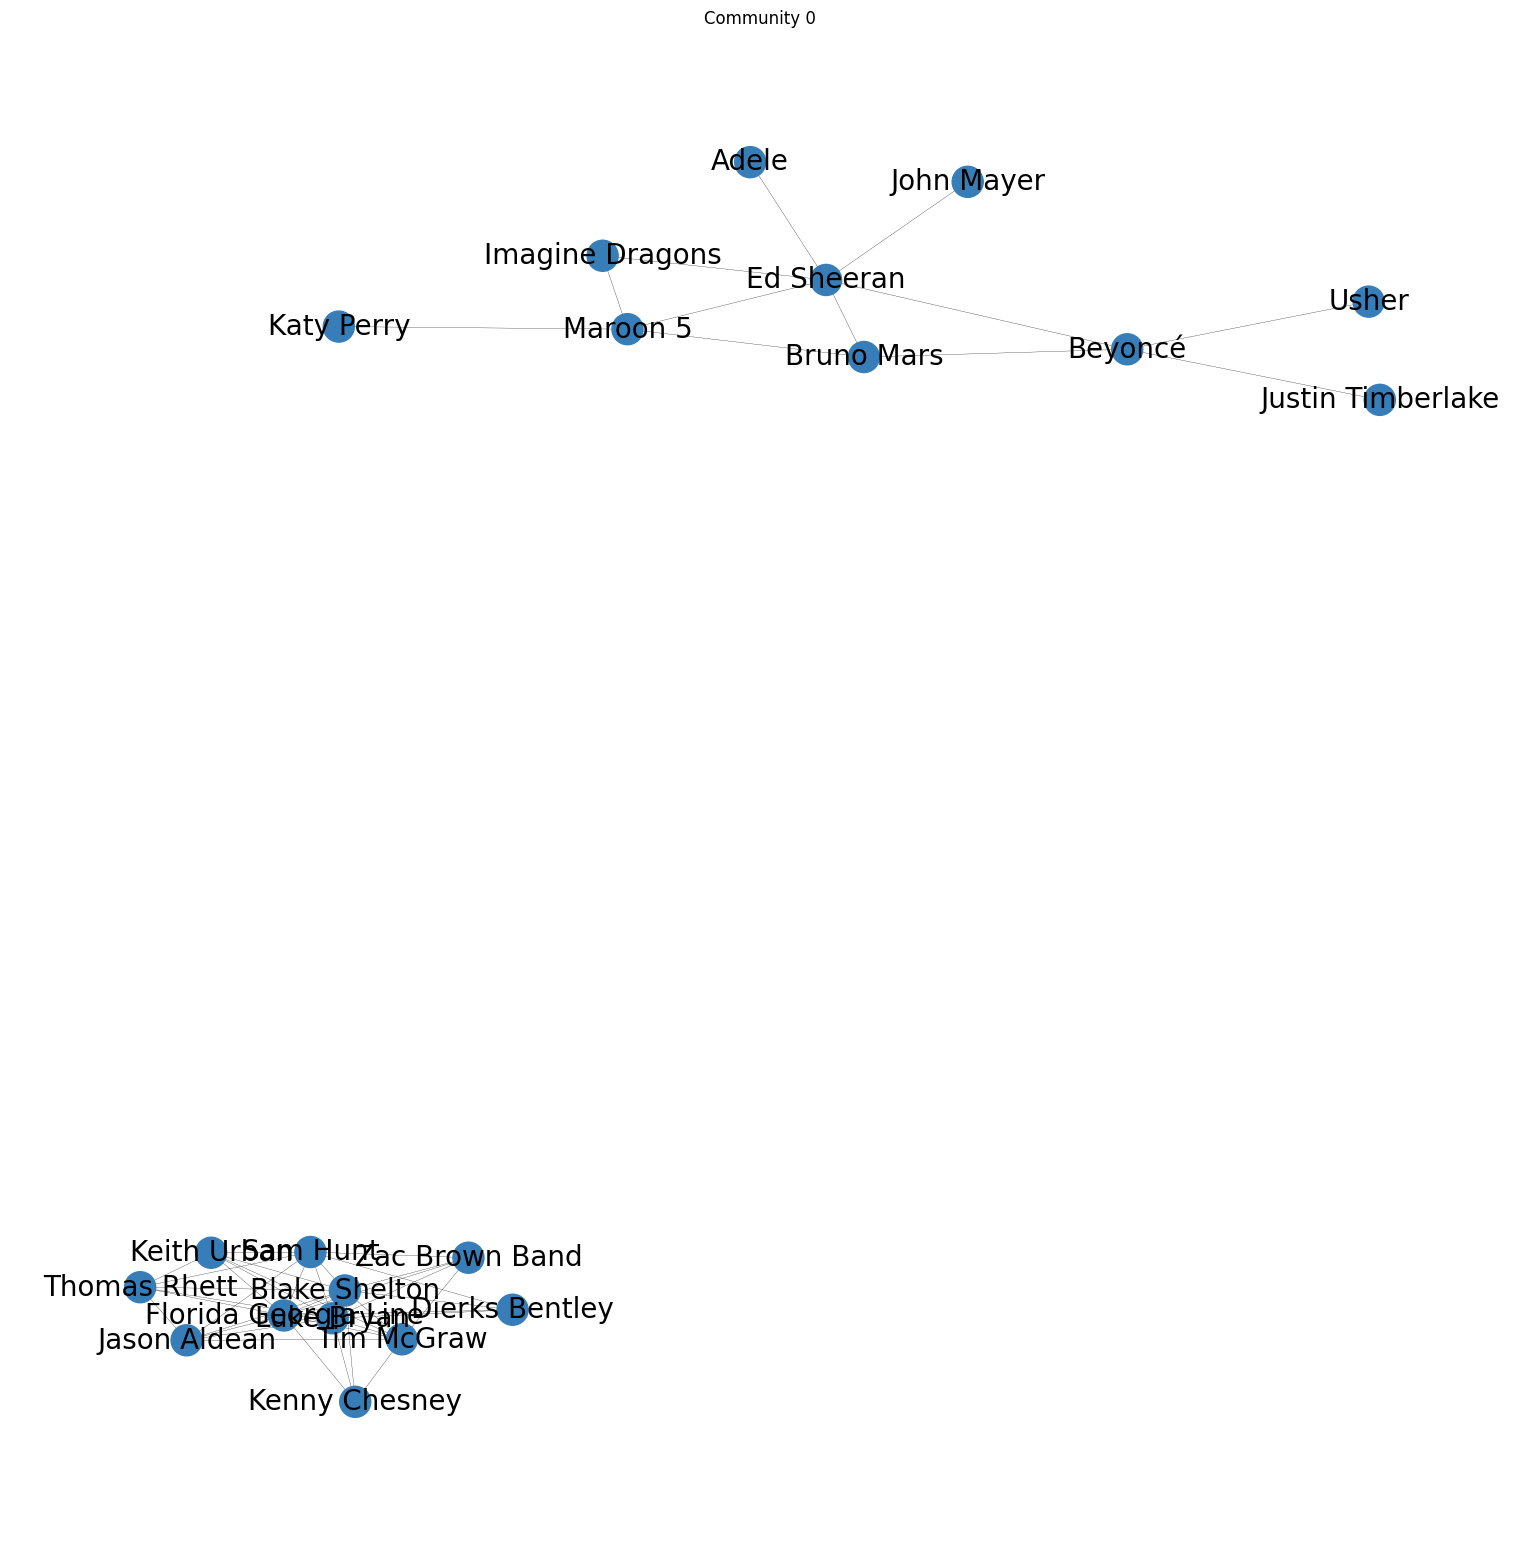

In [83]:
comm_nodes = communities[1]
subgraph = G0.subgraph(comm_nodes)
# get top 100 nodes by edge weight
top_nodes = sorted(subgraph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:50]
# create a new graph with only the top 100 edges
subgraph = nx.Graph()
subgraph.add_edges_from(top_nodes)
# Create a new figure for each community
plt.figure(figsize=(15, 15))

# Draw the subgraph with a distinct color
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos=pos, node_size=500, node_color=[colors[1]] * len(subgraph.nodes()), font_size=20, with_labels=True, width=0.2)

plt.title(f'Community 0')
plt.show()

# Rap dominating

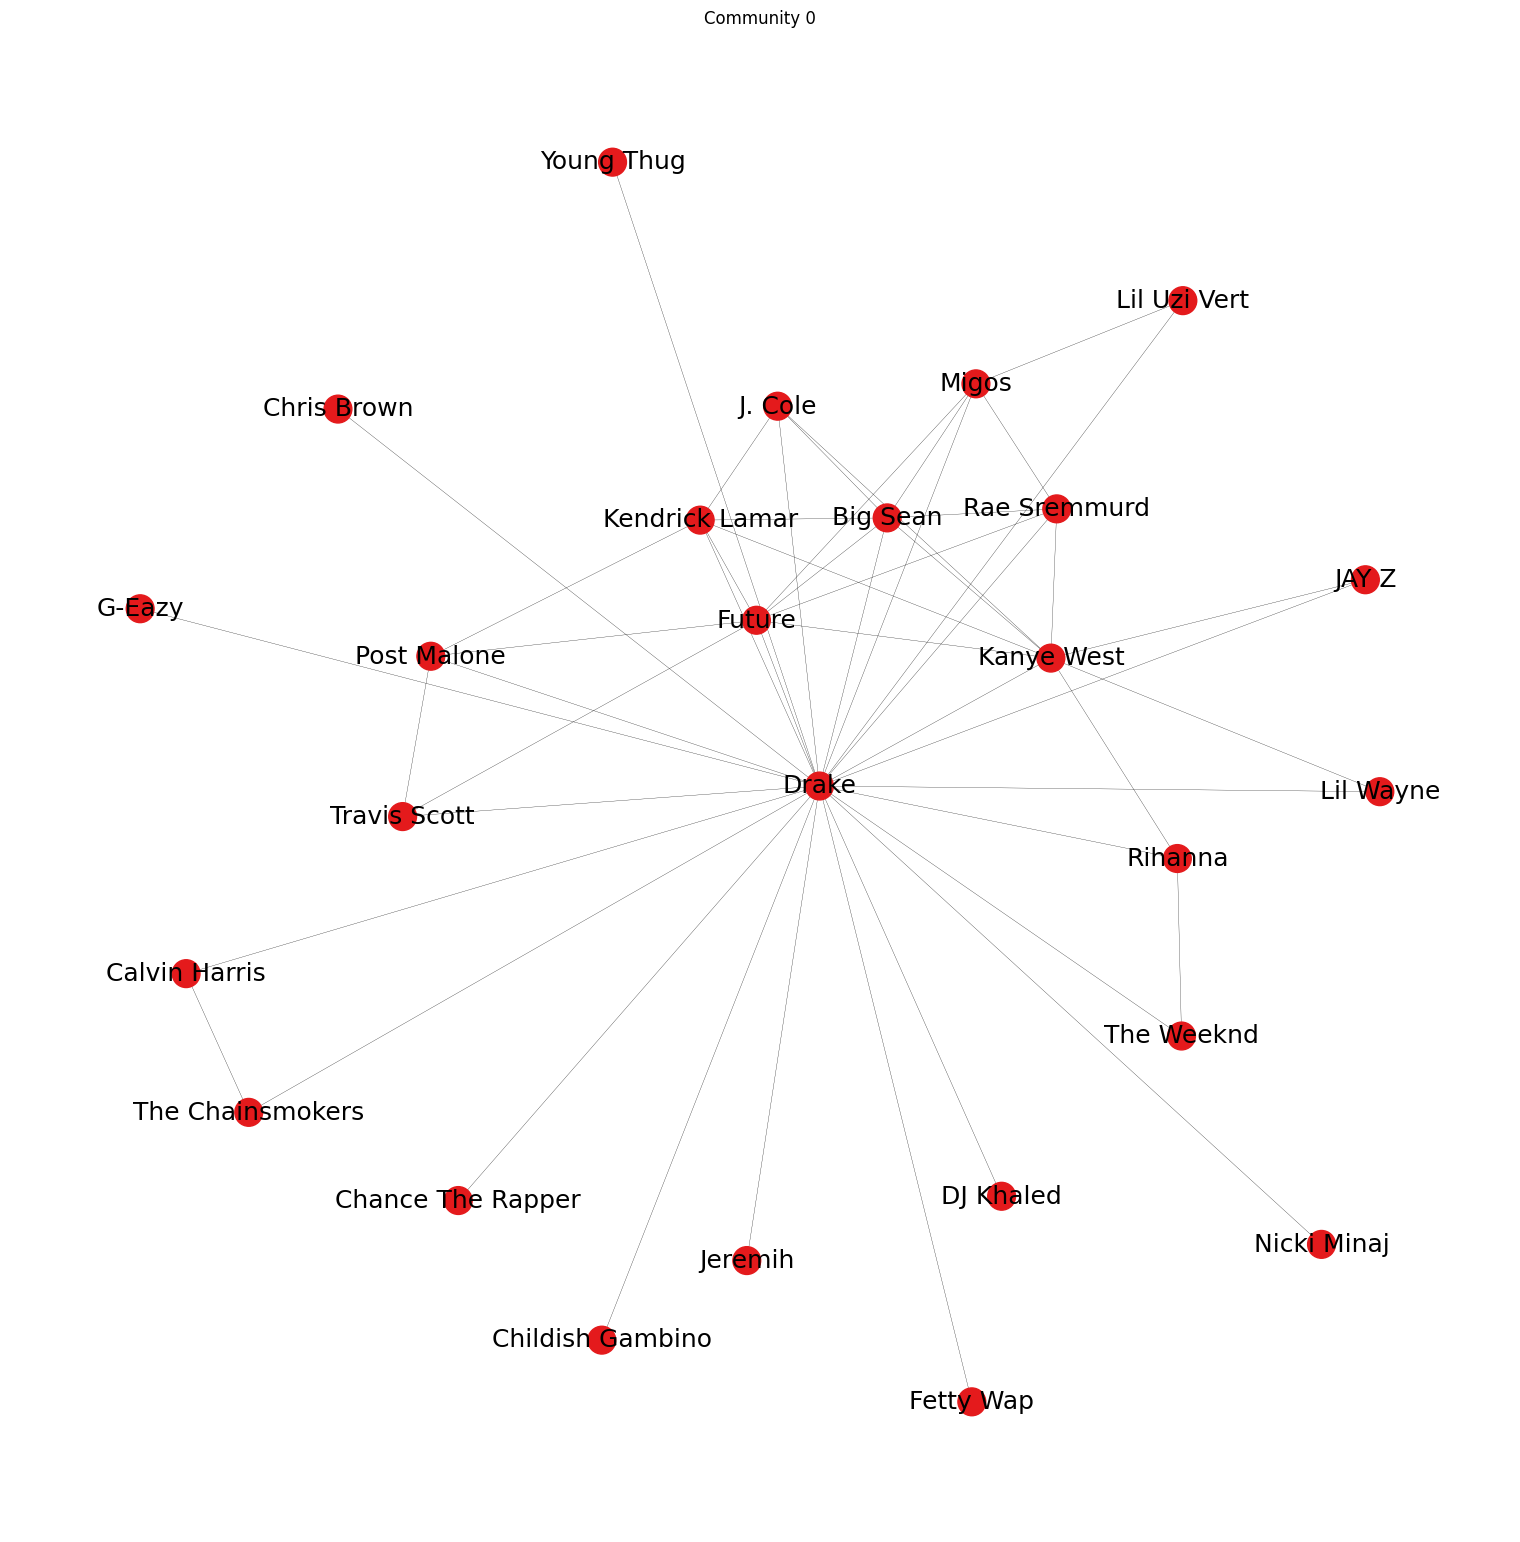

In [82]:
comm_nodes = communities[0]
subgraph = G0.subgraph(comm_nodes)
# get top 100 nodes by edge weight
top_nodes = sorted(subgraph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:50]
# create a new graph with only the top 100 edges
subgraph = nx.Graph()
subgraph.add_edges_from(top_nodes)
# Create a new figure for each community
plt.figure(figsize=(15, 15))

# Draw the subgraph with a distinct color
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos=pos, node_size=400, node_color=[colors[0]] * len(subgraph.nodes()), font_size=18, with_labels=True, width=0.2)

plt.title(f'Community 0')
plt.show()

# Latin american, spanish

ValueError: Received invalid argument(s): font_type

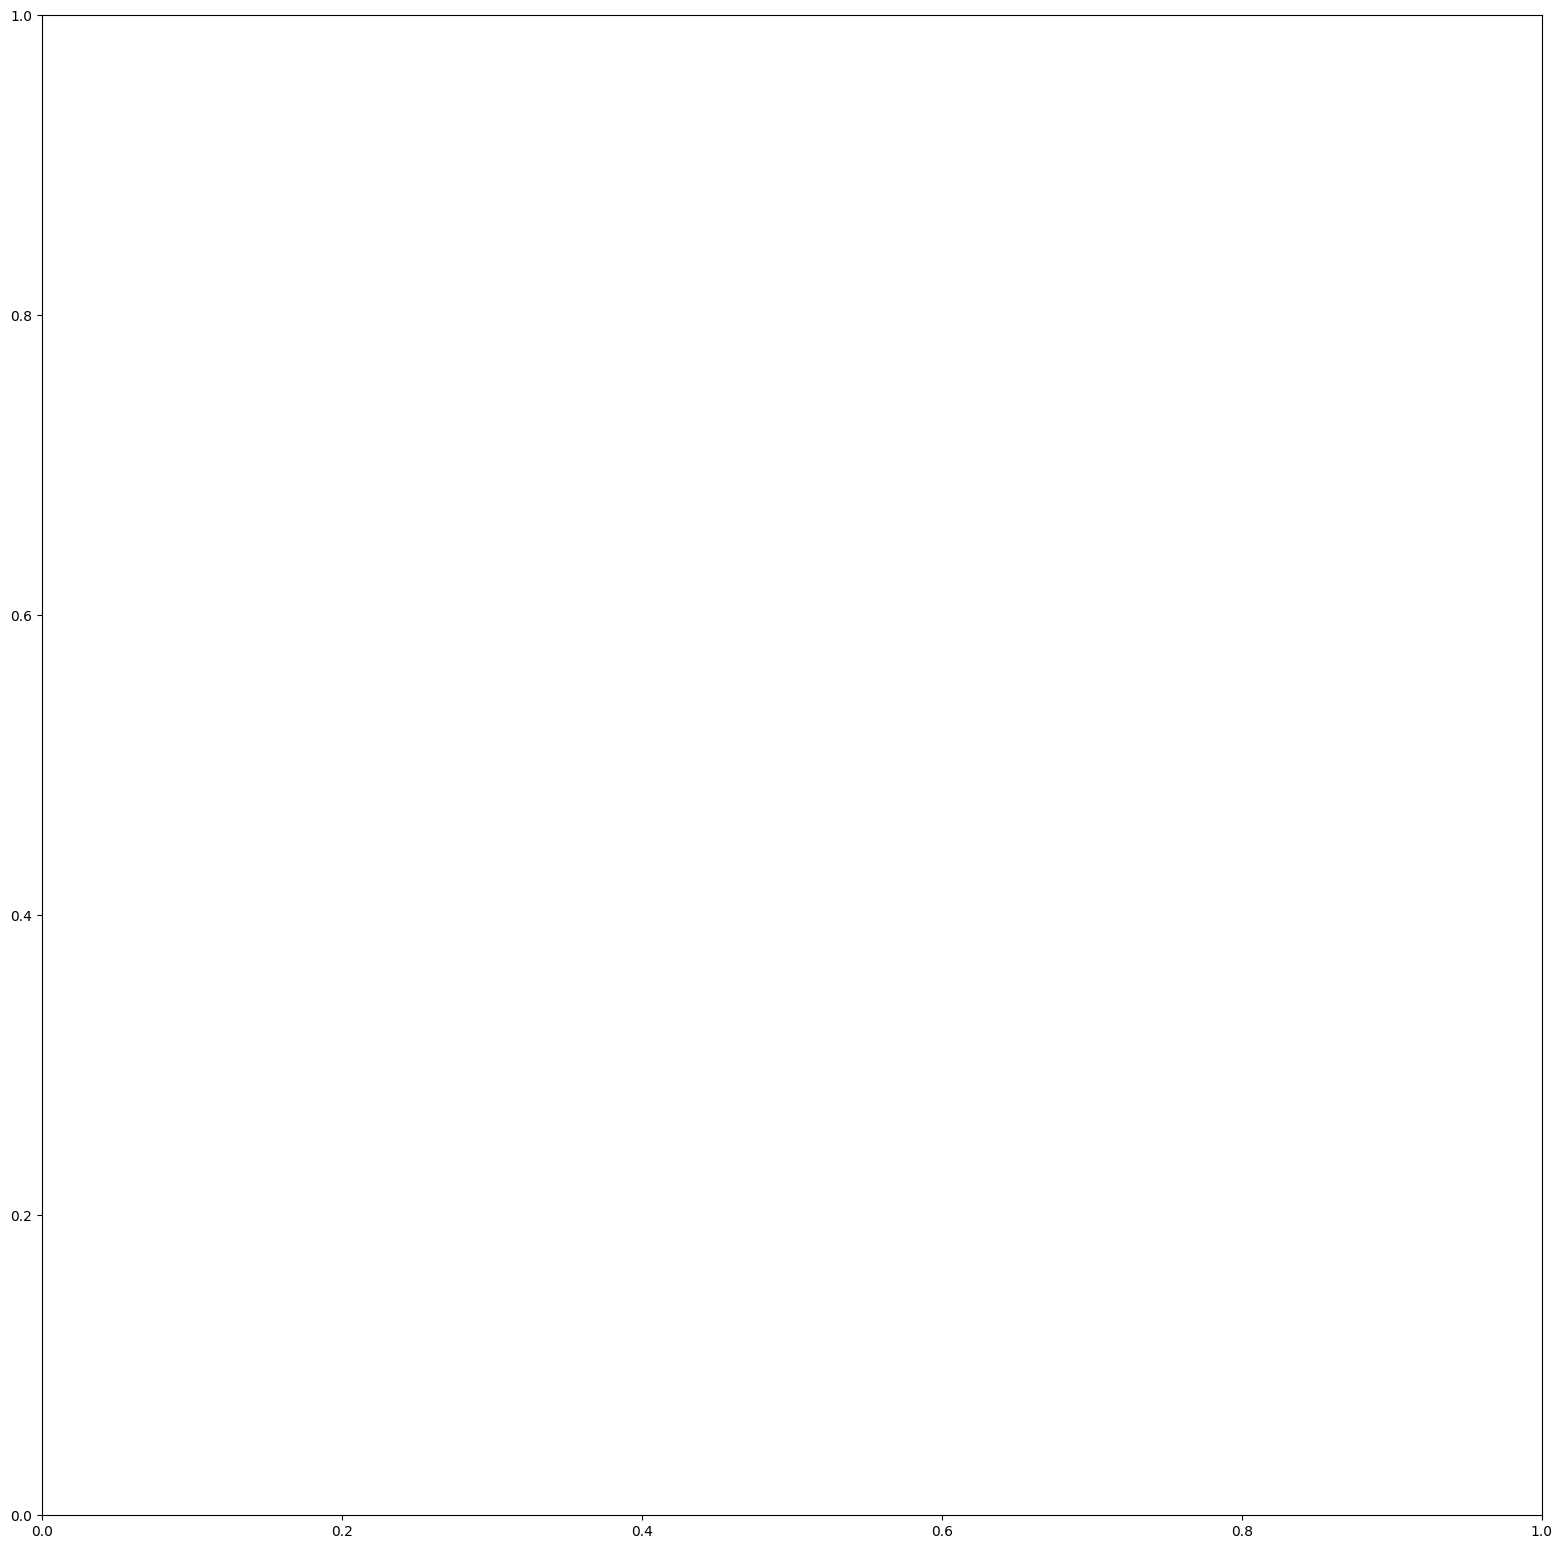

In [127]:
comm_nodes = communities[2]
subgraph = G0.subgraph(comm_nodes)

# Create a new figure for each community
plt.figure(figsize=(15, 15))

# Draw the subgraph with a distinct color
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos=pos, node_size=1000, node_color=[colors[2]] * len(subgraph.nodes()), font_size=16, with_labels=True, width=2)

plt.title(f'Community 2')
plt.show()

# Classical music

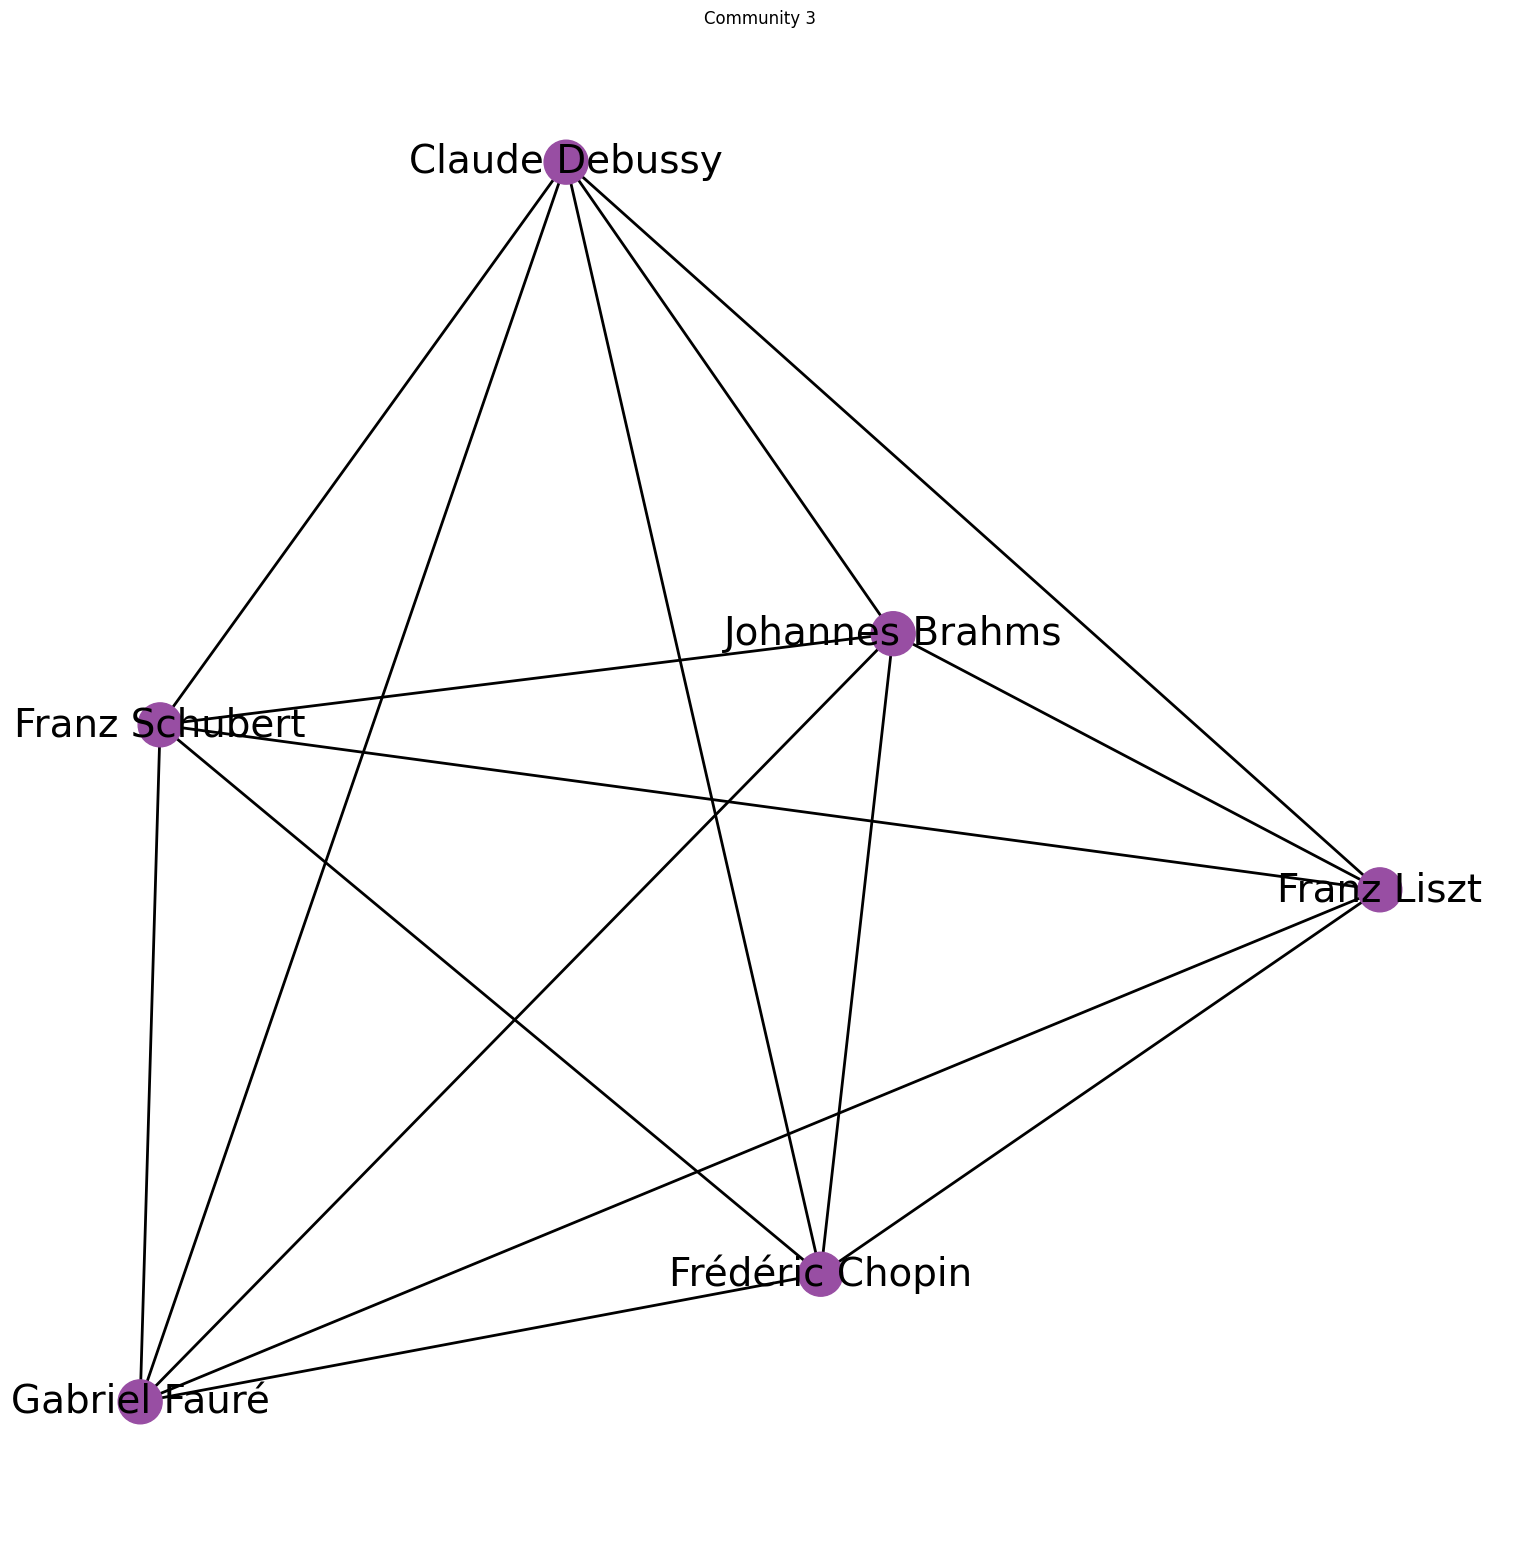

In [125]:
comm_nodes = communities[3]
subgraph = G0.subgraph(comm_nodes)

# Create a new figure for each community
plt.figure(figsize=(15, 15))

# Draw the subgraph with a distinct color
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos=pos, node_size=1000, node_color=[colors[3]] * len(subgraph.nodes()), font_size=28, with_labels=True, width=2)

plt.title(f'Community 3')
plt.show()

In [68]:
comm_nodes

frozenset({'Amigo the Devil',
           'Cutthroat Shamrock',
           'Filthy Still',
           'Gallows Bound',
           'Shawn James & the Shapeshifters'})

# Country, rock, folk fusion

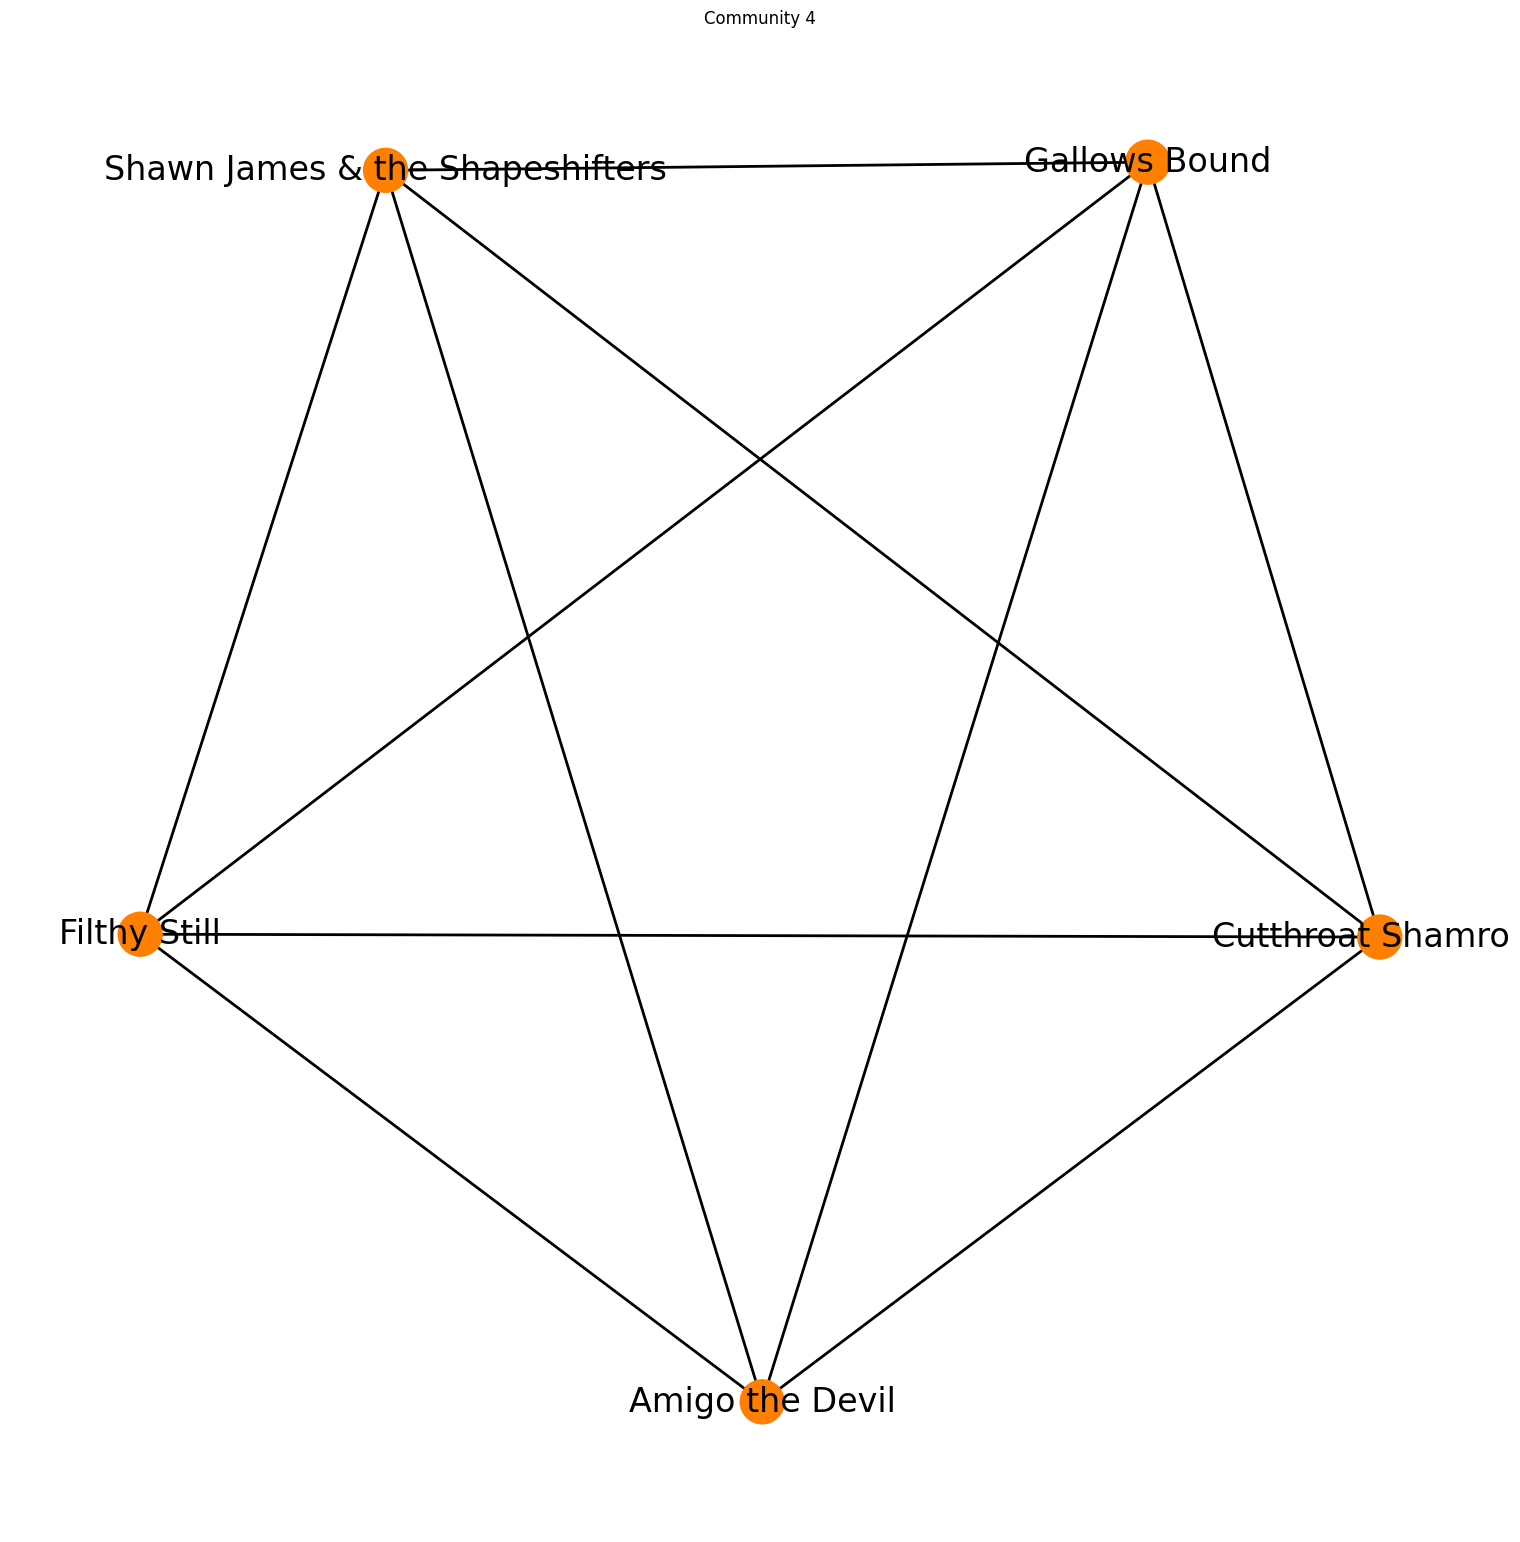

In [71]:
comm_nodes = communities[4]
subgraph = G0.subgraph(comm_nodes)

# Create a new figure for each community
plt.figure(figsize=(15, 15))

# Draw the subgraph with a distinct color
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos=pos, node_size=1000, node_color=[colors[4]] * len(subgraph.nodes()), font_size=24, with_labels=True, width=2)

plt.title(f'Community 4')
plt.show()

# Recommendation for my playlist

#  Weighted

In [113]:
import networkx as nx
pop_playlist = ['Maroon 5', 'Ed Sheeran', 'Imagine Dragons', 'The Chainsmokers', 'Twenty One Pilots']
# Assuming G is your weighted graph
user_playlist_nodes = set(pop_playlist)
similar_nodes = set()

for node in G0.nodes:
    if node not in user_playlist_nodes:
        common_neighbors = set(G0.neighbors(node)).intersection(user_playlist_nodes)
        jaccard_coeff = len(common_neighbors) / len(set(G0.neighbors(node)).union(user_playlist_nodes))
        
        # Taking edge weights into account
        weighted_jaccard_coeff = sum([G0[node][neighbor]['weight'] for neighbor in common_neighbors])
        
        similar_nodes.add((node, weighted_jaccard_coeff))

# Sort nodes by weighted Jaccard coefficient and recommend top k
weighted_pop_recommendations = sorted(similar_nodes, key=lambda x: x[1], reverse=True)[:5]

print(weighted_pop_recommendations)


[('Drake', 592), ('Calvin Harris', 582), ('Rihanna', 576), ('The Weeknd', 548), ('Bruno Mars', 498)]


In [114]:
import networkx as nx
rap_playlist = ["Eminem", "Drake", "Kendrick Lamar", "Travis Scott", "J. Cole"]

# Assuming G is your weighted graph
user_playlist_nodes = set(rap_playlist)
similar_nodes = set()

for node in G0.nodes:
    if node not in user_playlist_nodes:
        common_neighbors = set(G0.neighbors(node)).intersection(user_playlist_nodes)
        jaccard_coeff = len(common_neighbors) / len(set(G0.neighbors(node)).union(user_playlist_nodes))
        
        # Taking edge weights into account
        weighted_jaccard_coeff = sum([G0[node][neighbor]['weight'] for neighbor in common_neighbors])
        
        similar_nodes.add((node, weighted_jaccard_coeff))

# Sort nodes by weighted Jaccard coefficient and recommend top k
weighted_rap_recommendations = sorted(similar_nodes, key=lambda x: x[1], reverse=True)[:5]

print(weighted_rap_recommendations)

[('Kanye West', 1082), ('Big Sean', 864), ('Future', 860), ('Post Malone', 766), ('The Weeknd', 758)]


# Not weighted


In [116]:
import networkx as nx
pop_playlist = ['Maroon 5', 'Ed Sheeran', 'Imagine Dragons', 'The Chainsmokers', 'Twenty One Pilots']
# Assuming G is your weighted graph
user_playlist_nodes = set(pop_playlist)
similar_nodes = set()

for node in G0.nodes:
    if node not in user_playlist_nodes:
        common_neighbors = set(G0.neighbors(node)).intersection(user_playlist_nodes)
        jaccard_coeff = len(common_neighbors) / len(set(G0.neighbors(node)).union(user_playlist_nodes))
        
        similar_nodes.add((node, jaccard_coeff))

# Sort nodes by weighted Jaccard coefficient and recommend top k
pop_recommendations = sorted(similar_nodes, key=lambda x: x[1], reverse=True)[:5]

print(pop_recommendations)

[('Toby Fox', 0.13043478260869565), ('Random Encounters', 0.11538461538461539), ('Bo Burnham', 0.09090909090909091), ('Game Soundtrack Cat', 0.06060606060606061), ('The Big Pink', 0.06060606060606061)]


In [115]:
import networkx as nx
rap_playlist = ["Eminem", "Drake", "Kendrick Lamar", "Travis Scott", "J. Cole"]

# Assuming G is your weighted graph
user_playlist_nodes = set(rap_playlist)
similar_nodes = set()

for node in G0.nodes:
    if node not in user_playlist_nodes:
        common_neighbors = set(G0.neighbors(node)).intersection(user_playlist_nodes)
        jaccard_coeff = len(common_neighbors) / len(set(G0.neighbors(node)).union(user_playlist_nodes))
        
        similar_nodes.add((node, jaccard_coeff))

# Sort nodes by weighted Jaccard coefficient and recommend top k
rap_recommendations = sorted(similar_nodes, key=lambda x: x[1], reverse=True)[:5]

print(rap_recommendations)

[('Bass Outlaws', 0.12), ('HD', 0.10526315789473684), ('Mozzy', 0.10526315789473684), ('King Lil G', 0.10526315789473684), ('J. Stalin', 0.08695652173913043)]


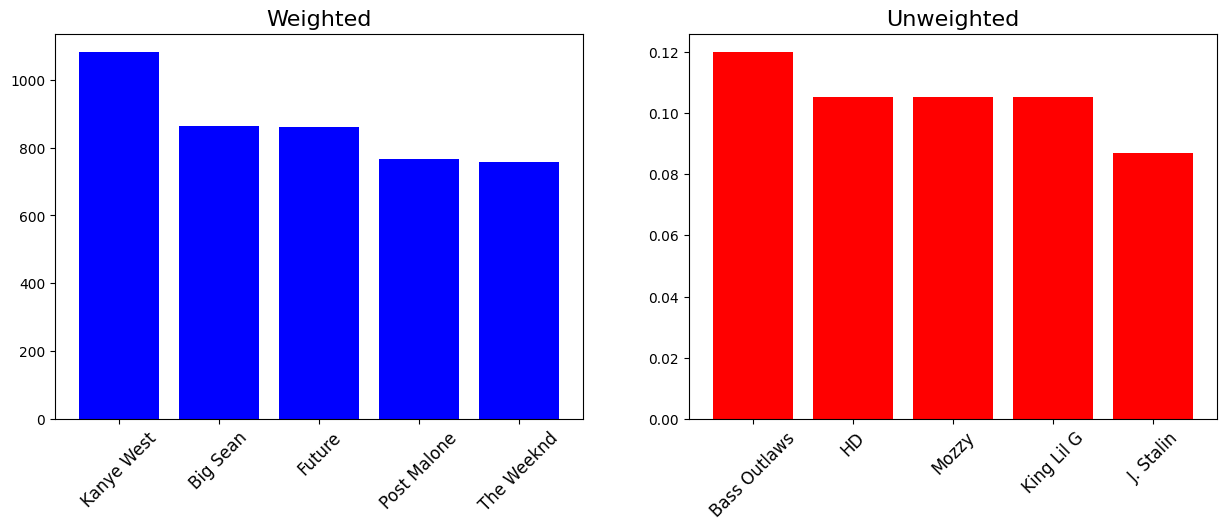

In [120]:
# plot weighted and unweighted recommendations
import matplotlib.pyplot as plt
import numpy as np

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the weighted recommendations
axes[0].bar(np.arange(5), [x[1] for x in weighted_rap_recommendations], color='b')
axes[0].set_xticks(np.arange(5))
axes[0].set_xticklabels([x[0] for x in weighted_rap_recommendations], rotation=45, fontsize=12)

# Plot the unweighted recommendations
axes[1].bar(np.arange(5), [x[1] for x in rap_recommendations], color='r')
axes[1].set_xticks(np.arange(5))
axes[1].set_xticklabels([x[0] for x in rap_recommendations], rotation=45, fontsize=12)

axes[0].set_title('Weighted', fontsize=16)
axes[1].set_title('Unweighted', fontsize=16)

plt.show()

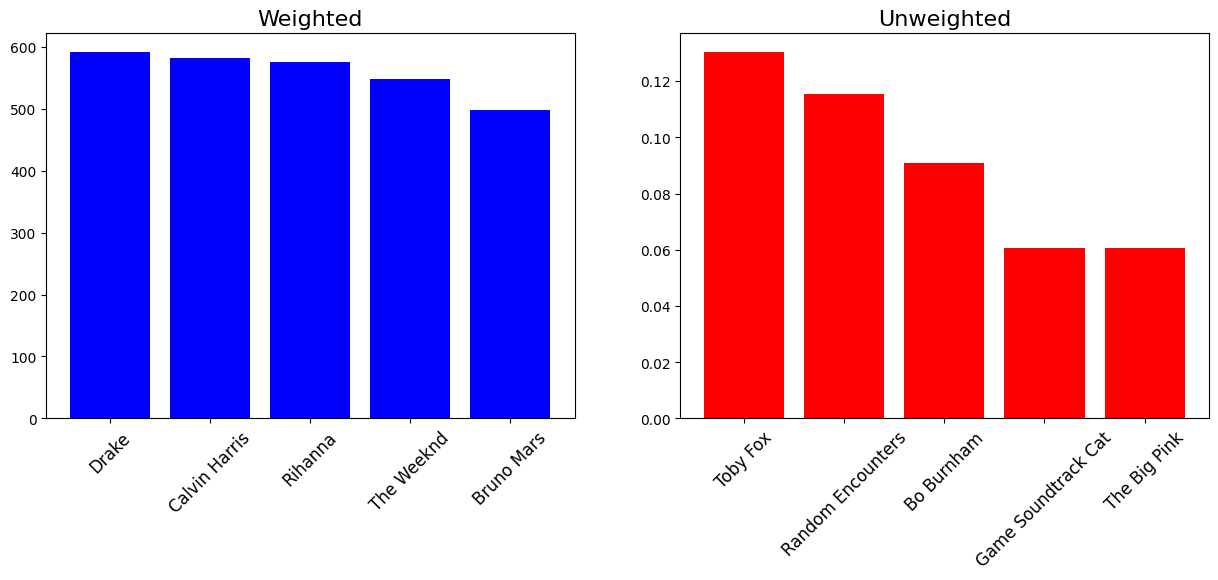

In [119]:
# plot weighted and unweighted recommendations
import matplotlib.pyplot as plt
import numpy as np

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the weighted recommendations
axes[0].bar(np.arange(5), [x[1] for x in weighted_pop_recommendations], color='b')
axes[0].set_xticks(np.arange(5))
axes[0].set_xticklabels([x[0] for x in weighted_pop_recommendations], rotation=45, fontsize=12)

# Plot the unweighted recommendations
axes[1].bar(np.arange(5), [x[1] for x in pop_recommendations], color='r')
axes[1].set_xticks(np.arange(5))
axes[1].set_xticklabels([x[0] for x in pop_recommendations], rotation=45, fontsize=12)

axes[0].set_title('Weighted', fontsize=16)
axes[1].set_title('Unweighted', fontsize=16)

plt.show()

# Top artists

In [3]:
df_artists = pd.read_csv('./data_CSV/artists.csv', header=None)
# also set the column names
df_artists.columns = ['count', 'artist_name']

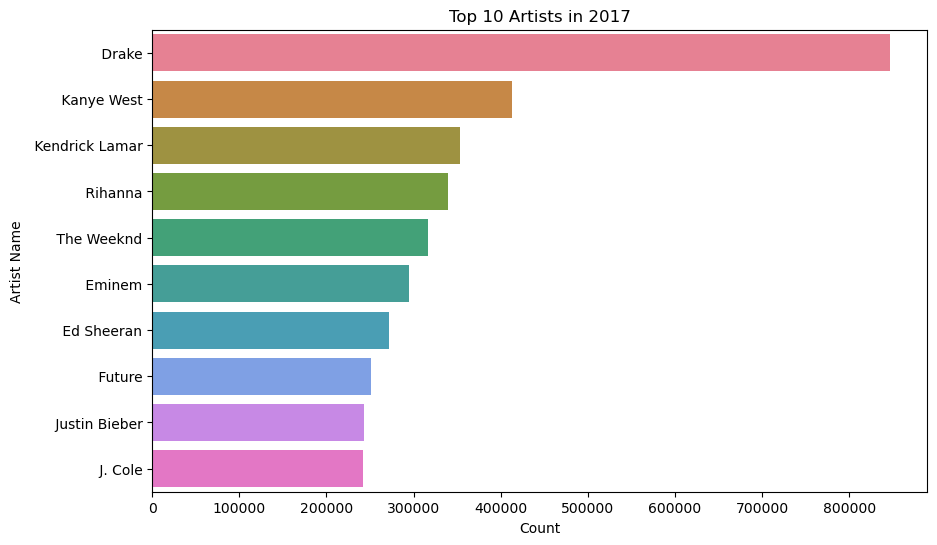

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


top_artists = df_artists.sort_values(by='count', ascending=False).head(10)
colors = sns.color_palette("husl", 10)

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='artist_name', data=top_artists, palette=colors)

plt.xlabel('Count')
plt.ylabel('Artist Name')
plt.title('Top 10 Artists in 2017')

plt.show()



# Top tracks

In [5]:
df_tracks = pd.read_csv('./data_CSV/tracks.csv', header=None)
df_tracks.columns = ['count', 'track_name']

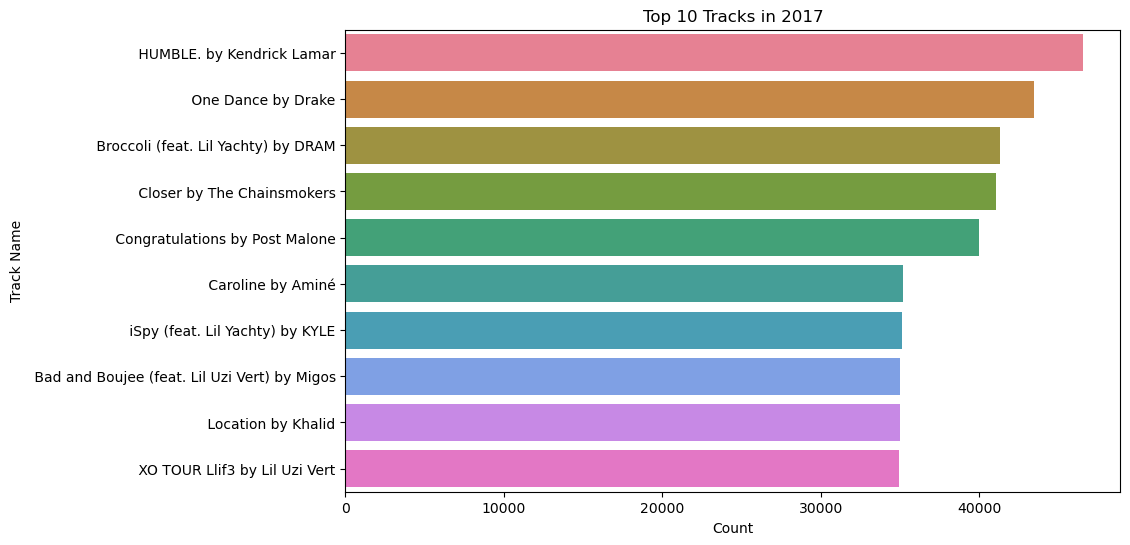

In [6]:
top_tracks = df_tracks.sort_values(by='count', ascending=False).head(10)
colors = sns.color_palette("husl", 10)

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='track_name', data=top_tracks, palette=colors)

plt.xlabel('Count')
plt.ylabel('Track Name')
plt.title('Top 10 Tracks in 2017')

plt.show()

